In [146]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from tqdm.auto import tqdm

import glob, os
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [34]:
class OwoDataset(Dataset):
  def __init__(self, path, transform=None):
    super(OwoDataset, self).__init__()
    self.path = path
    self.images = glob.glob(os.path.join(self.path, '*'))
    self.transform = transform
  def __len__(self):
    return len(self.images)
  def __getitem__(self, index):
    img = Image.open(self.images[index])
    if self.transform:
      img = self.transform(img)
    return img

transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5),
])

dataset = OwoDataset('./images', transform=transform)

In [85]:
train_dl = DataLoader(dataset, 32, shuffle=True, drop_last=True)
X_batch = next(iter(train_dl))

In [98]:
class ConvBlock(nn.Module):
  def __init__(self, ch_in, ch_out, norm=True):
    super(ConvBlock, self).__init__()
    self.has_norm = norm
    self.conv = nn.Conv2d(ch_in, ch_out, 3, 2, 1, bias=not norm)
    if self.has_norm:
      self.norm = nn.BatchNorm2d(ch_out)
    self.act = nn.LeakyReLU(0.02)
  def forward(self, X):
    Z = self.conv(X)
    if self.has_norm:
      Z = self.norm(Z)
    return self.act(Z)
class ConvTBlock(nn.Module):
  def __init__(self, ch_in, ch_out, correct=True, dropout=True):
    super(ConvTBlock, self).__init__()
    self.has_dropout = dropout
    self.conv = nn.ConvTranspose2d(ch_in, ch_out, 3, 2, 1, output_padding=int(correct))
    if self.has_dropout:
      self.dropout = nn.Dropout2d(0.25)
    self.act = nn.ReLU()
  def forward(self, X):
    Z = self.conv(X)
    if self.has_dropout:
      Z = self.dropout(Z)
    return self.act(Z)

In [208]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
      ConvBlock(3, 32),
      ConvBlock(32, 64),
      ConvBlock(64, 128),
      ConvBlock(128, 256),
      ConvBlock(256, 512),
      nn.AdaptiveAvgPool2d(output_size=(1, 1)),
      nn.Flatten(),
    )
    self.linear = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(512, 1)
    )
  def forward(self, X):
    return self.linear(self.net(X))

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.net = nn.Sequential(
      ConvTBlock(32, 512),
      ConvTBlock(512, 256),
      ConvTBlock(256, 128),
      ConvTBlock(128, 64, dropout=False),
      ConvTBlock(64, 32, dropout=False),
      nn.ConvTranspose2d(32, 3, 3, 2, 1, output_padding=1),
      nn.Sigmoid()
    )
  def forward(self, X):
    X = X.unsqueeze(-1).unsqueeze(-1)
    return self.net(X)

In [222]:
disc = Discriminator()
gen = Generator()

disc_optim = optim.AdamW(disc.parameters(), lr=1e-4, weight_decay=1e-9)
gen_optim = optim.AdamW(gen.parameters(), lr=1e-4, weight_decay=1e-9)

loss_fn = nn.BCEWithLogitsLoss()

real = X_batch
fake = gen(torch.randn(32, 32)).detach()

disc_real = disc(real)
disc_fake = disc(fake)

real_loss = loss_fn(disc_real, torch.ones_like(disc_real))
fake_loss = loss_fn(disc_fake, torch.zeros_like(disc_fake))

In [283]:
def train(dl, disc, gen, disc_optim, gen_optim, loss_fn, epochs, device):
  disc = disc.to(device)
  gen = gen.to(device)

  disc.train()
  gen.train()

  for epoch in range(epochs):
    pbar = tqdm(total=len(dl), desc=f'Epoch({epoch+1}/{epochs})', position=0, leave=True, colour='#ffff00')
    train_disc_loss = .0
    train_gen_loss = .0
    count_loss = 0

    for X in train_dl:
      X = X.to(device)

      fake = gen(torch.randn(X.shape[0], 32).to(device))
      real_logits = disc(X)
      fake_logits = disc(fake.detach())

      disc_loss = loss_fn(real_logits, torch.ones_like(real_logits)) + \
                  loss_fn(fake_logits, torch.zeros_like(fake_logits))

      disc_optim.zero_grad()
      disc_loss.backward()
      disc_optim.step()

      fake = gen(torch.randn(X.shape[0], 32).to(device))
      fake_logits = disc(fake)

      gen_loss = loss_fn(fake_logits, torch.ones_like(fake_logits))
      
      gen_optim.zero_grad()
      gen_loss.backward()
      gen_optim.step()

      train_gen_loss += gen_loss.item() * X.shape[0]
      train_disc_loss += disc_loss.item() * X.shape[0]
      
      count_loss += X.shape[0]
      
      pbar.set_postfix({'disc_loss': disc_loss.item(), 'gen_loss': gen_loss.item()})
      pbar.update(1)

    train_gen_loss /= count_loss
    train_disc_loss /= count_loss
    pbar.colour = None
    pbar.set_postfix({'disc_loss': train_disc_loss, 'gen_loss': train_gen_loss})
    pbar.close()

train(train_dl, disc, gen, disc_optim, gen_optim, loss_fn, 3, device)

Epoch(1/3):   3%|▎         | 3/97 [00:01<00:50,  1.86it/s, disc_loss=1.3, gen_loss=0.73]  

KeyboardInterrupt: 

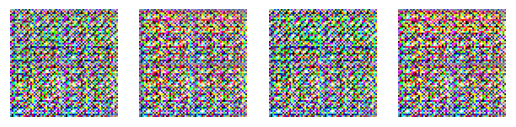

In [282]:
def generate(gen):
  with torch.no_grad():
    gen.eval()
    fake = gen(torch.randn(4, 32)).detach()
    for i in range(4):
      plt.subplot(1, 4, i+1)
      img = fake[i].moveaxis(0, 2).numpy()
      plt.axis('off')
      plt.imshow(img)
    plt.show()
generate(gen)